### Настройка среды

In [1]:
import os
import sys

### Yandex Datasphere
# sys.path.append(os.path.abspath(".."))

### Google Colab
!git clone https://github.com/Belashov641618/OpticalEncoder.git
sys.path.append(os.path.abspath("OpticalEncoder"))

fatal: destination path 'OpticalEncoder' already exists and is not an empty directory.


In [2]:
%cd OpticalEncoder
!dir
!git pull

/content/OpticalEncoder
datasets  elements  main.py  notebooks	parameters.py  __pycache__  tests  utilities
Already up to date.


In [3]:
%pip install belashovplot

In [4]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
from itertools import product

In [5]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 11
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 11
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 11
FontLibrary.Fonts.RowDescriptionRight.FontSize = 11

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Распространение от щели

In [7]:
N = 500
size = 30.0E-6

b_spatial_coherence = 50.0E-6
b_time_coherence = 10.0E-9
b_time_relaxation = 1.0E-6
b_mean_samples = 1000

b_length = 10.0E-3
b_wavelength = 500E-9
b_distance = b_length*sqrt((size/b_wavelength)**2-1)

## Зависимость от степени пространственной некогерентности и дистанции

In [8]:
distance_samples = 10
coherence_samples = 10
slices = 100

distance_array = numpy.linspace(b_distance*0.1, b_distance, distance_samples)
spatial_coherence_array = numpy.linspace(5.0E-6, b_length, coherence_samples)

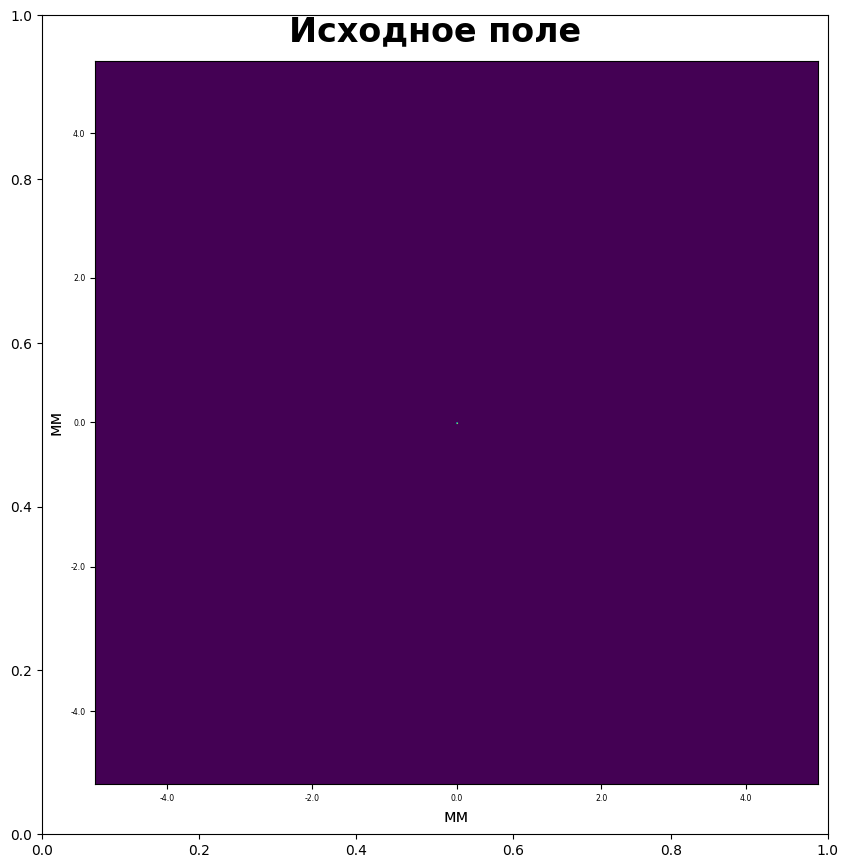

In [9]:
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - int(N*size/(b_length*2))
p1 = p0 + int(N*size/b_length)
initial[0,0,p0:p1,p0:p1] = 1.0

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Исходное поле')
formatter, unit = engineering.separatedformatter(b_length, 'м')

axes = plot.axes.add(0,0)
axes.imshow(initial[0,0].abs().cpu(), aspect='auto', extent=[-b_length/2, +b_length/2]*2)
axes.xaxis.set_major_formatter(formatter)
axes.yaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
plot.graph.label.y(unit)

plot.show()

In [ ]:
with torch.no_grad():
  results = []
  chunker = CudaMemoryChunker(sub_chunks=10).to(device)
  for (col, spatial_coherence), (row, max_distance) in tqdm(product(enumerate(spatial_coherence_array), enumerate(distance_array)), total=distance_samples*coherence_samples):
    incoherent = Incoherent(spatial_coherence, b_time_coherence, b_time_relaxation, b_mean_samples, N, b_length).to(device)
    result = torch.zeros((slices, N), dtype=torch.float32)
    for i, distance in enumerate(numpy.linspace(0, max_distance, slices)):
      propagation = FurrierPropagation(N, b_length, b_wavelength, 1.0, 0.0, distance).to(device)
      chunker.attach_forward(propagation.forward)
      incoherent.attach_forward(chunker.forward)
      result[i] = incoherent.forward(initial)[0,0,N//2].abs().cpu()
    results.append((col, row, spatial_coherence, max_distance, result))
    result = None

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Распространение при различных параметрах')
kwargs = {'aspect':'auto', 'extent':[-b_length/2,+b_length/2]*2, 'interpolation':'nearest'}
formatter, unit = engineering.separatedformatter(b_length, 'м')

for col, spatial_coherence in enumerate(spatial_coherence_array):
  plot.description.column.top(f"Когерентность: {engineering(spatial_coherence, 'м')}", col)

for row, distance in enumerate(distance_array):
  plot.description.row.left(f"Дистанция: {engineering(distance, 'м')}", row)

for col, row, spatial_coherence, distance, data in results:
  axes = plot.axes.add(col, row)
  axes.imshow(data, **kwargs)
  axes.xaxis.set_major_formatter(formatter)
  axes.yaxis.set_major_formatter(formatter)
  plot.graph.label.x(unit)
  plot.graph.label.y(unit)